In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from scipy.io import arff

from torch import nn, optim

import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('./UNSW_NB15/UNSW_NB15_training-set.arff') as f:
  train = arff.loadarff(f)

with open('./UNSW_NB15/UNSW_NB15_testing-set.arff') as f:
  test = arff.loadarff(f)

In [4]:
df_train = pd.DataFrame(train[0])
df_test = pd.DataFrame(test[0])

df = pd.concat([df_train, df_test], ignore_index=True)
df = df.sample(frac=1.0)
df['target'] = df['target'].str.decode('utf-8')
print(df.shape)

(5000, 141)


In [5]:
df.head(-50)

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1501,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2586,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2653,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
1055,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
705,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,0.935927,-0.801292,-2.607226,-4.153241,-4.581588,-4.060781,-3.097560,-1.948507,-1.462350,-1.336988,...,0.712352,0.694556,0.642980,0.582280,0.677093,1.432817,1.514706,0.577914,-1.714425,1
1955,2.269201,1.739325,-0.161533,-1.911548,-3.169654,-4.046274,-3.208732,-2.016326,-1.750840,-1.531970,...,0.109758,0.608347,0.943498,1.056860,1.630956,1.816857,2.074166,1.464609,1.823835,1
3152,-0.546934,-1.396696,-1.991434,-2.426758,-2.534147,-2.295610,-1.950019,-1.282993,-0.705821,-0.634589,...,-0.640139,-0.750114,-1.188292,-1.915452,-2.559198,-3.548960,-4.621795,-4.358757,-3.275815,3
34,1.006661,-0.712977,-2.109085,-3.256289,-4.003786,-3.319976,-2.224466,-1.824146,-1.600101,-0.552590,...,0.088748,0.717941,0.771131,0.922755,1.682838,1.807232,1.642135,0.777403,1.170199,1


In [6]:
CLASS_NORMAL = 1

class_names = ['Normal','Exploits','DoS','Worms','Ransomware']

In [7]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [8]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

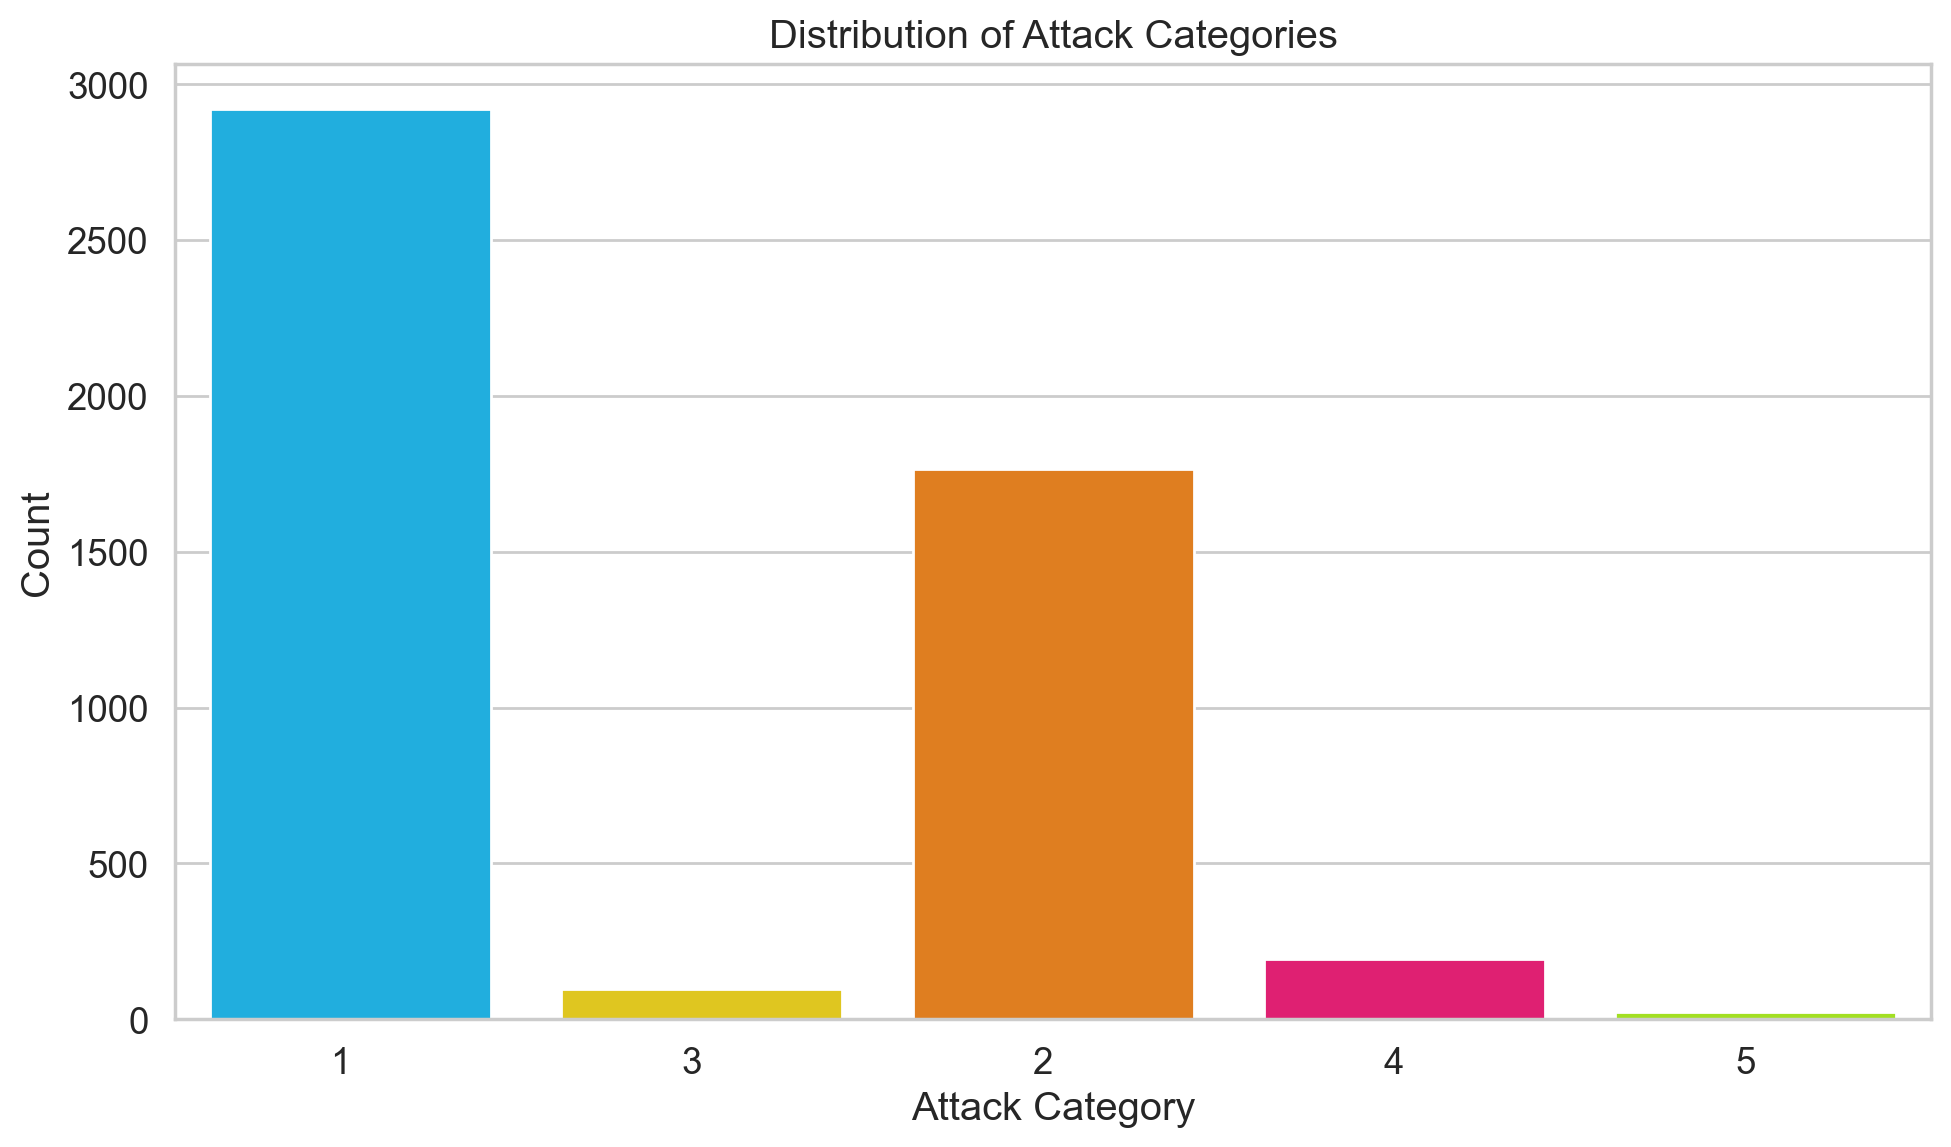

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='target')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Distribution of Attack Categories')

plt.tight_layout()
plt.show()

In [10]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

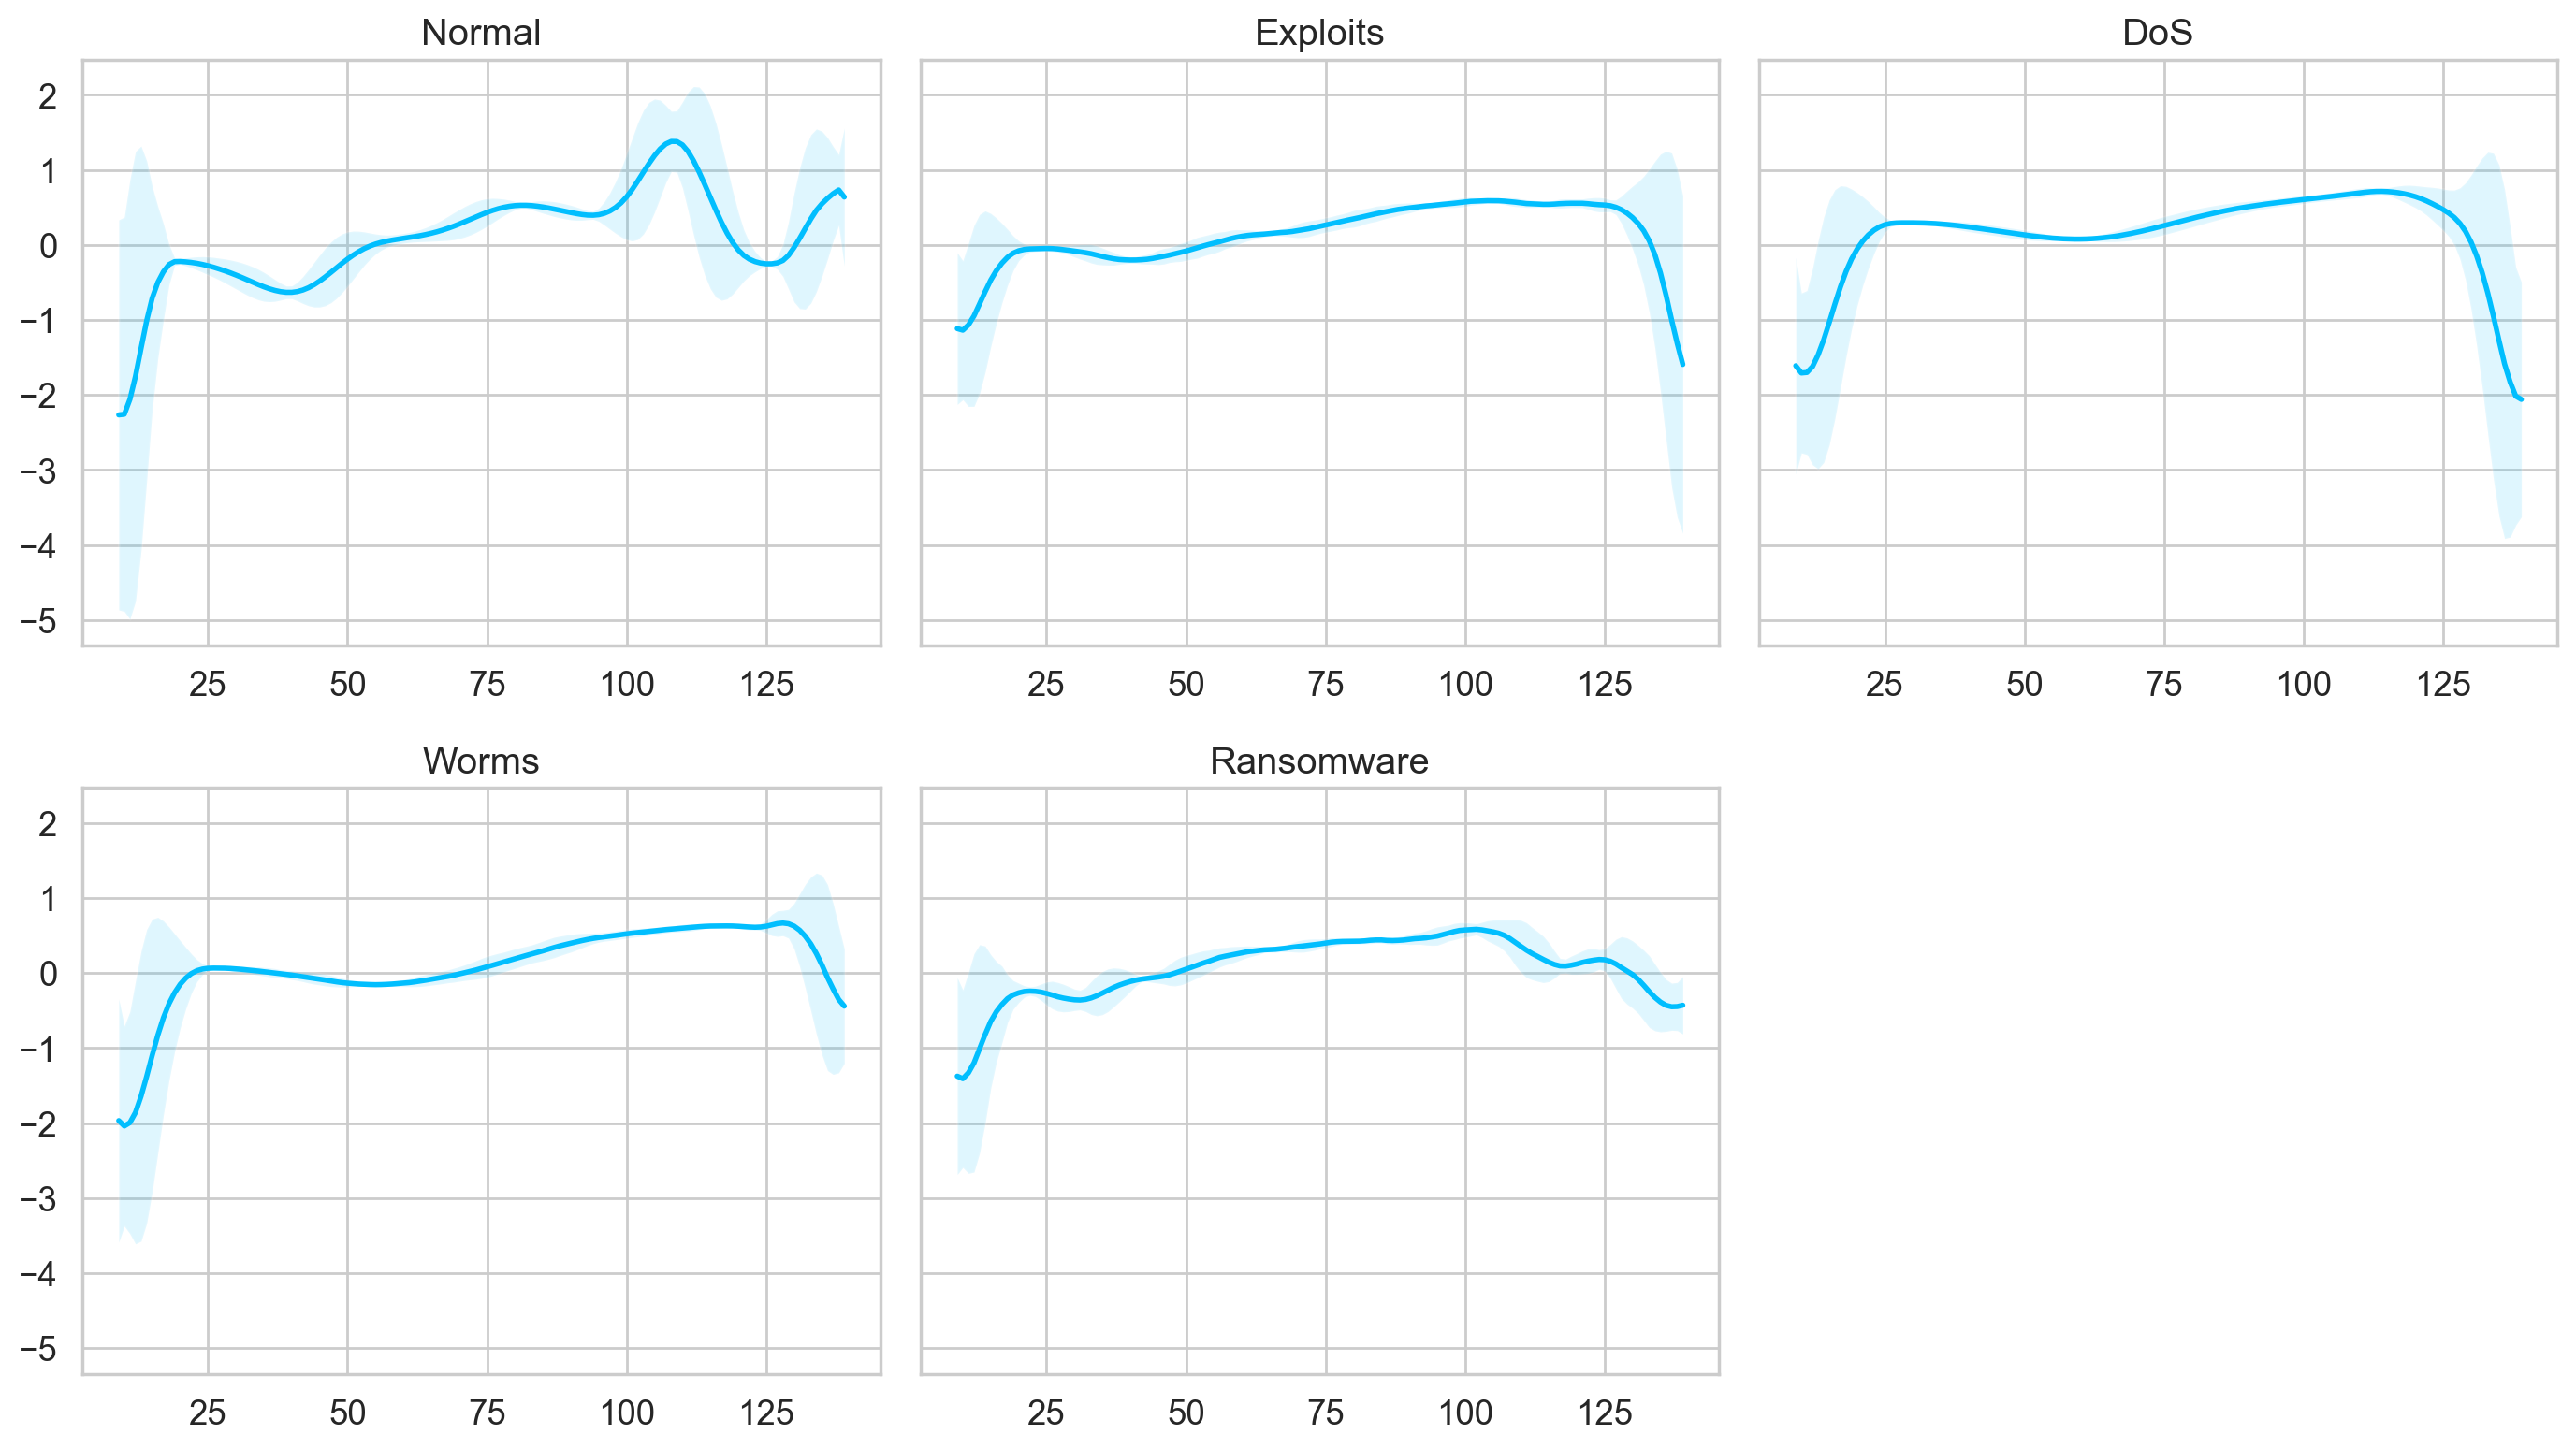

In [11]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();